In [3]:
# Import packages
import pandas as pd
import numpy as np
import statistics
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pycountry_convert as pc
from sklearn.linear_model import LinearRegression

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [7]:
# Import data
test = pd.read_csv("../01-data/test.csv", low_memory = False)

# Custom data
codebook = pd.read_csv("../01-data/codebook_compact.csv", low_memory = False) # OG codebook+dtypes from codebook_long

# Fill missing responses with "." so that they can be counted and categorized as missing later on
test_no_blanks = test.fillna('.')

0.27% of the ages are missing.
0.76% of the years are missing.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.17% of the numbers are missing.
There are 63 features with over 50% missing.


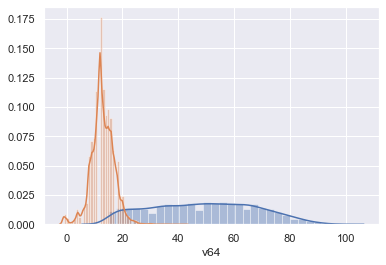

In [8]:
# Dealing with country vars on a case-by-case basis
cat_cols = ['v17', "v20", "v25", "v78", "v154", "v155", "v161", "cntry"]
cat_df = test[cat_cols]

## V17: Country of Birth

# Drop 99, 2, 4, 3, 77, 6
to_drop = ['99', '2', '4', '3', '77', '6', '88']
test['v17'] = test['v17'].replace(to_drop, ".")

def convert_country(country):
    try:
        return(pc.country_alpha2_to_continent_code(country))
    except:
        return(country)

test['v17'] = test['v17'].apply(lambda x: convert_country(x))

# Only one observation is from TL, and none exist in the test set. Drop ID = 2441
test = test[test.v17 != 'TL']

test['v17'].value_counts()

## V20: Region

# Country code + more specific region code. Convert to just country
# After stripping specific region code, only 6% of obs have a different entry here than for 'cntry'. Drop this column.
test = test.drop('v20', axis = 1)

## V25: Citizenship

# Drop 65, 99, 6, convert rest to continents
to_drop = ['65', '99', '6', '88']
test['v25'] = test['v25'].replace(to_drop, '.')
test['v25'] = test['v25'].apply(lambda x: convert_country(x))

## V78: Country of birth, father AND V161: Country of birth, mother

# Drop errors, convert rest to continents
to_drop = ['99', '88', '2', '4', '3', '77', '6']
test['v78'] = test['v78'].replace(to_drop, '.')
test['v78'] = test['v78'].apply(lambda x: convert_country(x))

test['v161'] = test['v161'].replace(to_drop, '.')
test['v161'] = test['v161'].apply(lambda x: convert_country(x))

## V154: Language most often spoken at home: first mentioned

# Drop errors
to_drop = ['999','888','777']
test['v154'] = test['v154'].replace(to_drop, '.')

# Leaving ENG and GER as is 
missing = ["."]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO"]
bal = ["CZE", "LIT"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE"]
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON"]

languages = {language: 'EUR' for language in eur}
languages.update({language: '.' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

test['v154'] = test['v154'].map(languages)

test['v154'].value_counts(normalize = True)

## V155: Language most often spoken at home: second mentioned

# Assuming 0 means no other language, and 999, 888, 777 are missing
to_drop = ['999','888','777']
test['v155'] = test['v155'].replace(to_drop, '.')

## Check if any weren't present in the previous question
lang_v154 = ["GER","ENG","FRE","CZE","LIT","FIN","POL","DUT","SWE","HEB","SPA",
             "HUN","DAN","NOR","POR","EST","SLV","RUS","GSW","ARA","CAT","TUR",
             "ITA","GLG","SRP","BOS","ALB","FRS","RUM","KUR","HRV","BAQ","URD",
             "PER","AMH","APA","ROA","CHI","HIN","ARM","GLE","SOM","SLO","IRA",
             "TAM","GEM","GUJ","ROM","CPP","FRM","GRE","WEL","VIE","BUL","UKR",
             "YID","BER","PAP","MIS","BEN","SLA","LAV","MAL","THA","TGL","NEP",
             "MAY","SYR","AZE","UZB","PAN","TGK","MLG","ROH","TIR","MAN","TAI",
             "LIN","KAB","EGY","BEL","WOL","BAM","TIB","AKA","SWA","IND","SUX",
             "TEL","FAO","JPN","SRN","SUS","ICE","SNK","FIL","ABK","GEO","TIG",
             "NAP","AST","FRO","LAO","CPF","MON","MDR"]

lang_v155 = test['v155'].unique().tolist()

new_languages = [language for language in lang_v155 if language not in lang_v154]

# New language dict: leaving ENG and GER as is 
none = ['0']
missing = ["."]
GER = ["GER"]
ENG = ["ENG"]
eur = ["FRE","DUT","SPA","HUN","POR","GSW","CAT","ITA","GLG","ALB","FRS","HRV","BAQ","ROA","GLE",
       "GEM","CPP","FRM","GRE","WEL","ROH","BEL","FAO","SRN","NAP","AST","FRO","ENM","OCI","BRE",
       "NDS","WLN","VOL","MWL"]
bal = ["CZE", "LIT", "MAC", "CSB"]
afr = ["AMH","SOM","BER","MLG","TIR","MAN","LIN","WOL","BAM","AKA","SWA","SUX","SUS","SNK","TIG",
       "EWE","RUN","IBO","YOR","FON","KON","DYU","KIN","NIC","NDE","HER","KIK"]
nor = ["FIN","SWE","DAN","NOR","EST","ICE", 'SMN']
asia = ["CHI","VIE","THA","MAY","TAI","TIB","IND","JPN","LAO"]
southa = ["URD","HIN","TAM","GUJ","BEN","MAL","PAN","TEL","CPF", "MAR"]
mideast = ["HEB","ARA","TUR","KUR","PER","ARM","IRA","YID","SYR","AZE","UZB","TGK","KAB","EGY","ABK","GEO"]
slav = ["POL","SLV","RUS","SRP","BOS","RUM","HRV","SLO","ROM","BUL","UKR","SLA","LAV","MDR"]
oth = ["APA","PAP","MIS","TGL","NEP","FIL","MON","ZXX","TPI","GRN","SGN","HUP","NAH","HAT","CAD","PHI","MAO"]

 
languages = {language: 'EUR' for language in eur}
languages.update({language: '0' for language in none})
languages.update({language: '.' for language in missing})
languages.update({language: 'GER' for language in GER})
languages.update({language: 'ENG' for language in ENG})
languages.update({language: 'BAL' for language in bal})
languages.update({language: 'AFR' for language in afr})
languages.update({language: 'NOR' for language in nor})
languages.update({language: 'ASIA' for language in asia})
languages.update({language: 'SOUTHA' for language in southa})
languages.update({language: 'MIDEAST' for language in mideast})
languages.update({language: 'SLAV' for language in slav})
languages.update({language: 'OTHER' for language in oth})

# Map langauges to their groups
test['v155'] = test['v155'].map(languages)

test['v155'].value_counts(normalize = True)

## V3: Age of respondent, calculated

missing_age = round(len(test[test['v3'] == '.a'])/len(test) * 100, 2)
print(str(missing_age) + "% of the ages are missing.")

# Using EDA notebook, the highest positive and negatively linearly correlated vars with Age (v3):
# Positive: v217, v163, v218, v103, v99
# Negative: v54, v196, v208, v100, v159	
cols = ['v3','v217','v218', 'v54']

regress_age = test[cols]
train_lr = regress_age[regress_age['v3'] != '.a']
test_lr = regress_age[regress_age['v3'] == '.a']

for col in cols:
    train_lr[col] = pd.to_numeric(test[col], errors = 'coerce')

# Drop all na
train_lr = train_lr.dropna()

X_train = train_lr.loc[:, train_lr.columns != 'v3']
y_train = train_lr['v3']

# Linear regression
regressor = LinearRegression()  
regressor.fit(X_train, y_train) 

del test_lr['v3']
test_lr = test_lr.replace(['.a', '.b', '.c', '.d'], np.nan).dropna()

test_lr["predicted_age"] = regressor.predict(test_lr)

# Gives R2 score of 0.63 but better than imputation by mean
# metrics.r2_score(label, test_no_na["predicted_age"])

# Filling in missing values with predicted age
index_predicted = test_lr.drop(['v217','v218', 'v54'], axis = 1).index
index_missing = test[test['v3'] == '.a'].index

test = test.join(test_lr['predicted_age'])
test['v3_imputed'] = np.where(test['v3'] == '.a', test['predicted_age'], test['v3']).astype("float64")

# Delete other versions of age
del test['v3']
del test['predicted_age']

# Plot age distribution
sns.set(color_codes=True)
sns.distplot(test['v3_imputed'].astype("float64"));

# (37.0, 44.0]
# (23.0, 31.0]
# (44.0, 50.0]
# (61.0, 67.0]
# (55.0, 61.0]
# (13.999, 23.0]
# (74.423, 114.0]
# (67.0, 74.423]
# (31.0, 37.0]
# (50.0, 55.0]

bin_labels = [1,2,3,4,5,6,7,8,9,10]
test['v3_binned'] = pd.qcut(test['v3_imputed'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

del test['v3_imputed']

# Drop v102 as it is almost the same as v103 but with less information
del test['v102']

# Drop v57, v59, v61, v63 as v56, v58, v60, v62 gives the same information but mapped to categories
del test['v57']
del test['v59']
del test['v61']
del test['v63']

# V64: Years of full time education completed

# Combine all missing
test['v64'] = pd.to_numeric(test['v64'], errors='coerce')

missing_age = round(len(test[test['v64'].isnull()])/len(test) * 100, 2)
print(str(missing_age) + "% of the years are missing.")

# Plot distribution
sns.distplot(test['v64'].fillna(-1));

# Fill with mean bc I'm tired
test['v64'] = pd.to_numeric(test['v64'], errors = 'coerce')
mean_years = np.nanmean(test['v64'])
test['v64'] = test['v64'].fillna(mean_years)

## Now bin education
test['v64'].describe()

bin_labels = [1,2,3,4,5]
test['v64_binned'] = pd.qcut(test['v64'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

test['v64_binned'].value_counts()
del test['v64']

## V100: Number of people living regularly as member of household
# Group everything more than 6 into "6+", i.e. 6

# Combine all missing
test['v100'] = pd.to_numeric(test['v100'], errors='coerce')

missing_age = round(len(test[test['v100'].isnull()])/len(test) * 100, 2)
print(str(missing_age) + "% of the numbers are missing.")

# Fill with mean
mean_years = np.nanmean(test['v100'])
test['v100'] = test['v100'].fillna(mean_years).astype("int64")

# Grouping large values
test['v100_grouped'] = np.where(test['v100'] > 6, 6, test['v100']).astype("int64")
test['v100_grouped'].value_counts()

# v128: End of interview, month
# v129: Start of interview, month
# End and start of interview are only not equal for 0.18% of observations
# We keep v129 since there are no missing
del test['v128']

# Define: 3-5 = Spring, 6-8 = Summer, 9-11 = Autumn, 12-2 = Winter - in Germany
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]

# Dictionary for seasons
seasons = {season: 'WI' for season in winter}
seasons.update({season: 'SP' for season in spring})
seasons.update({season: 'SU' for season in summer})
seasons.update({season: 'AU' for season in autumn})

# Map langauges to their groups
test['start_interview_season'] = test['v129'].map(seasons)
test['start_interview_season'].value_counts(normalize = True)

# Delete original variable
del test['v129']

# v126: end of interview, hour
# v130: start of interview, hour

# Impute with mean
test['v126'] = pd.to_numeric(test['v126'], errors='coerce')
test['v126'] = test['v126'].fillna(np.nanmean(test['v126'])).astype('int64')
test['v130'] = pd.to_numeric(test['v130'], errors='coerce')
test['v130'] = test['v130'].fillna(np.nanmean(test['v130'])).astype('int64')

bin_labels = [1,2,3,4,5]
test['v126_binned'] = pd.qcut(test['v126'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)
test['v130_binned'] = pd.qcut(test['v130'], q=[0,0.2,0.4,0.6,0.8,1], labels=bin_labels)

# Delete original variables
del test['v126']
del test['v130']

# v132: Interview length in minutes - bin in quantiles
pd.qcut(test['v132'], q = 10).value_counts()

bin_labels = [1,2,3,4,5,6,7,8,9,10]
test['v132_binned'] = pd.qcut(test['v132'], q=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], labels=bin_labels)

# Delete original variable
del test['v132']

# Treating missing 
test_nodots = test.replace([".", ".a", ".b", ".c", ".d"], [np.nan, np.nan, np.nan, np.nan, np.nan])
percent_missing_nodots = test_nodots.isnull().sum() * 100 / len(test_nodots)
missing_value_df_nodots = pd.DataFrame({'column_name': test_nodots.columns,
                                 'percent_missing': percent_missing_nodots})

# Columns where % missing > some percent
percent = 50
cols_missing = missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent]
n_cols_missing = len(missing_value_df_nodots[missing_value_df_nodots.percent_missing > percent])
print("There are " + str(n_cols_missing) + " features with over " + str(percent) + "% missing.")

# Attach short desc for more context
codebook_labels = ['Variable', "Label"]
missing = cols_missing.merge(codebook[codebook_labels], left_on = 'column_name', right_on = "Variable", how = "left")
missing.sort_values(by = "percent_missing", ascending = False)

# Try keeping ALL of them and imputing with -1 for now.
dots = [".", ".a", ".b", ".c", ".d", np.nan]
test_imputed = test.replace(dots, [-1, -1, -1, -1, -1, -1])

one_hot = ['v17','v25','v78','v161', 'v154', 'v155', 'start_interview_season']
test_encoded = pd.get_dummies(test_imputed, prefix=one_hot, columns=one_hot)

In [10]:
test_encoded.to_csv("test_FE.csv")